# DESI Robot Keepouts

In [1]:
%matplotlib inline

In [46]:
from ast import literal_eval as safe_eval

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [13]:
import fpoffline.db
import fpoffline.io
import fpoffline.scripts.endofnight

In [8]:
import pandas as pd

In [5]:
DB = fpoffline.db.DB()

In [14]:
calib = fpoffline.scripts.endofnight.get_calib(DB)

Loaded 502 calib rows for petal_id 4
Loaded 502 calib rows for petal_id 5
Loaded 502 calib rows for petal_id 6
Loaded 502 calib rows for petal_id 3
Loaded 507 calib rows for petal_id 8
Loaded 506 calib rows for petal_id 10
Loaded 503 calib rows for petal_id 11
Loaded 510 calib rows for petal_id 2
Loaded 502 calib rows for petal_id 7
Loaded 502 calib rows for petal_id 9


In [41]:
snapshot, snap_time = fpoffline.io.get_snapshot()

In [40]:
def get_unique_keepouts():

    for arm in 'theta', 'phi':
        radial, angular = f'keepout_expansion_{arm}_radial', f'keepout_expansion_{arm}_angular'
        signatures = list(zip(np.round(calib[radial],3), np.round(calib[angular],3)))
        unique = set(signatures)
        print(f'Found {len(unique)} unique {arm} keepouts')
        for (rad,ang) in unique:
            mask = np.array([ sig == (rad,ang) for sig in signatures ])
            nmask = np.count_nonzero(mask)
            is_nonfunc = calib.device_classified_nonfunctional[mask]
            num_nonfunc = np.count_nonzero(is_nonfunc)
            print(f'  radial expansion = {rad} mm, angular expansion = {ang} deg: {nmask} robots ({num_nonfunc} non functional)')
            if nmask < 30:
                pos_ids = calib.pos_id[mask]
                #print('   ',','.join([f"'{p}'" for p in pos_ids]))
                print('   ',','.join(pos_ids))

get_unique_keepouts()

Found 4 unique theta keepouts
  radial expansion = 0.0 mm, angular expansion = 10.0 deg: 19 robots (15 non functional)
    M05797,M05970,M04980,M02668,M01133,M04386,M01956,M04712,M04722,M03545,M03945,M03503,M03979,M01758,M01491,M02258,M07715,M01759,M02254
  radial expansion = -0.5 mm, angular expansion = -7.0 deg: 26 robots (4 non functional)
    M03873,M05074,M05365,M02769,M03777,M04074,M05496,M03167,M04530,M05748,M05885,M03661,M03935,M03981,M03329,M05371,M07689,M01967,M07712,M01669,M01096,M01959,M04233,M07694,M03436,M02242
  radial expansion = 0.05 mm, angular expansion = 10.0 deg: 86 robots (84 non functional)
  radial expansion = 0.0 mm, angular expansion = 0.0 deg: 4907 robots (531 non functional)
Found 10 unique phi keepouts
  radial expansion = 0.0 mm, angular expansion = 10.0 deg: 38 robots (27 non functional)
  radial expansion = 0.2 mm, angular expansion = 20.0 deg: 1 robots (1 non functional)
    M03809
  radial expansion = 0.0 mm, angular expansion = 0.0 deg: 4864 robots (5

In [42]:
canonical = lambda k: np.round(safe_eval(k), 3)

In [57]:
def get_keepouts(snap, arm):
    nsnap = len(snap)
    keepouts = [canonical(snap.meta[f"general_keepout_{arm}"])]
    keepout_idx = np.full(nsnap, -1, int)

    for j, row in enumerate(snap):
        k = canonical(row[f"KEEPOUT_{arm}"])
        for i, ki in enumerate(keepouts):
            if np.array_equal(k, ki):
                keepout_idx[j] = i
                break
        if keepout_idx[j] == -1:
            keepout_idx[j] = len(keepouts)
            x, y = k
            plt.plot(x, y, 'k-', lw=1)
            keepouts.append(k)

    print(f"Found {len(keepouts)} unique {arm} keepouts for {nsnap} devices")
    return np.array(keepouts), keepout_idx

Found 4 unique T keepouts for 5020 devices


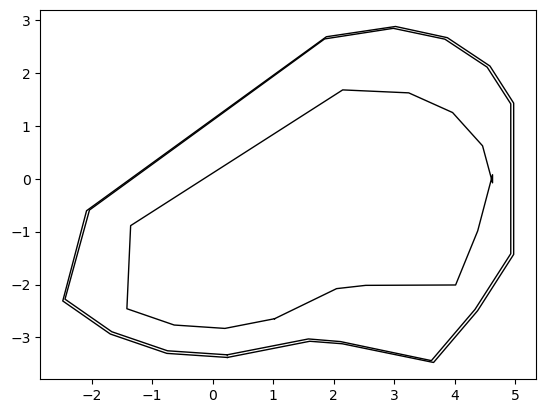

In [62]:
get_keepouts(snapshot, 'T');
plt.savefig('theta_keepouts.jpg')

Found 1006 unique P keepouts for 5020 devices


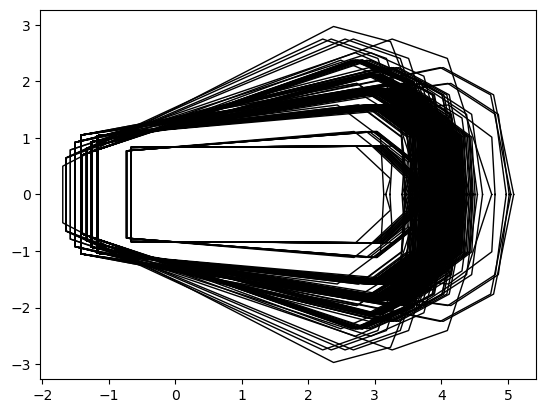

In [63]:
get_keepouts(snapshot, 'P');
plt.savefig('phi_keepouts.jpg')